Приветик! Перед тобой очередное захватывающее домашнее задание по АБ-тестированию. Возьми чай или кофе, усаживайся поудобнее, настрой музыку в свой ритм, и поехали!

In [1]:
import numpy as np
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from statsmodels.stats.proportion import proportion_confint

sns.set(palette='Set2', style='whitegrid', font_scale=1.3)

In [2]:
def draw_interval(
    real_alpha, left_alpha, right_alpha, 
    alpha=0.05, figsize=(7, 2)
):
    '''
    Отрисовка интервала для реального уровня значимости
    real_alpha -- оценка уровня значимости
    left_alpha, right_alpha -- границы доверительного интервала
    alpha -- теоретический уровень значимости
    figsize -- размер фигуры matplotlib
    '''
    
    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(6, 2))
        plt.hlines(0, 0, 1, color='black', lw=2, alpha=0.6)
        plt.vlines(alpha, -1, 1, color='red', lw=5, linestyle='--', alpha=0.6)
        plt.fill_between(
            [left_alpha, right_alpha], [0.15]*2, [-0.15]*2, 
            color='green', alpha=0.6
        )
        plt.scatter(real_alpha, 0, s=300, marker='*', color='red')
        plt.xlim((min(alpha, left_alpha)-1e-3, max(alpha, right_alpha)+1e-3))
        plt.title(
            f'Доля отвержений = {100*real_alpha:.2f}%, '
            f'интервал ({100*left_alpha:.2f}%, {100*right_alpha:.2f}%)'
        )
        plt.ylim((-0.5, 0.5))
        plt.yticks([])
        plt.tight_layout()
        plt.show()

In [3]:
def calculate_real_alpha(n_errors, n_iter):
    '''
    Оценка реального уровня значимости и его дов. интервала.
    
    Аргументы:
    n_errors -- количество ошибок в эксперименте
    n_iter -- количество экспериментов
    
    Возвращает:
    real_alpha -- оценка реального уровня значимости
    left_alpha, right_alpha -- границы соотв. дов. интервала
    '''
    
    real_alpha = n_errors / n_iter
    left_alpha, right_alpha = proportion_confint(n_errors, n_iter, method='wilson')
    
    return real_alpha, left_alpha, right_alpha

In [4]:
def AA_test(
    test, generate_sample_x, 
    n_iter=10000, sample_size=1000, alpha=0.05, 
    effect=0, relative_effect=True, feature_values='session_lengths'
):
    '''
    Проведение серии AA-тестов на искусственных выборках.
    
    Аргументы:
    test -- статистический критерий
    generate_sample_x -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости
    effect -- величина эффекта для оценки мощности
    relative_effect -- относительный или абсолютный эффект
    feature_values -- название признака, для которого проводится тест
    '''

    n_errors = 0  # количество отвержений H_0

    # Проведение экспериментов
    for _ in tqdm(range(n_iter)):
        # Генерируем выборки
        x = generate_sample_x(size=sample_size)
        y = generate_sample_x(size=sample_size)
        
        # Добавляем эффект, если хотим оценить мощность
        if relative_effect:
            x[feature_values] *= 1 + effect
        else:
            x[feature_values] += effect
        
        n_errors += test(x, y)

    # Реальный уровень значимости
    real_alpha, left_alpha, right_alpha = calculate_real_alpha(n_errors, n_iter)
    draw_interval(real_alpha, left_alpha, right_alpha, alpha=alpha)

---

### Задача 1.

Начнем с очень простой задачки для разогрева. Напомним, для ratio-метрик мы хотим подобрать критерий, удовлетворяющий следующим свойствам:
1. Корректность &mdash; контролирование вероятности ошибки 1 рода;
2. Сонаправленность метрики критерия с исходной ratio-метрикой;
3. Возможность применения CUPED для повышения чувствительности.

Возьмем функцию генерации искусственных данных с занятия, в которой также генерируются предэкспериментальные данные. Будем рассматривать 1000 пользователей. 

**1.** Проверь визуально, насколько выполняется сонаправленность для метода бакетов в зависимости от количества бакетов. Рассмотри случаи 10, 20, 30, 50 бакетов, и, может быть, несколько других.

*Ты же понимаешь, что надо позапускать код с занятия для разных параметров? :)*

In [5]:
alpha = 0.05  # Теоретический уровень значимости
sample_size = 1_000  # Размер выборок
n_iter = 5000  # Количество итераций валидации
feature = 'session_lengths'

In [6]:
def generate_session_sample(
    n_users=100, mean_session_count=15, effect=0
):
    '''
    Генерация данных пользовательских сессий
    
    n_users -- количество пользователей
    mean_session_count -- среднее количество сессий на пользователя
    effect -- добавляемый эффект
    '''
    
    # Параметр формы гамма-распределения для каждого пользователя
    user_parameters = np.random.uniform(size=n_users, low=1, high=20)
    # Количество сессий каждого пользователя
    user_session_counts = 1 + np.random.poisson(
        size=n_users, lam=mean_session_count
    )
    
    users = []
    session_lengths = []
    # Для каждого пользователя генерируем все его сессии
    for user_id in range(n_users):
        users += [f'id_{user_id}'] * user_session_counts[user_id]
        session_lengths += list(np.random.gamma(
            shape=user_parameters[user_id], 
            size=user_session_counts[user_id]
        ) * (1 + effect))
        
    # Заносим в табличку
    data = pd.DataFrame({
        'user_id': users,
        'session_lengths': np.array(session_lengths, dtype=float)
    })
        
    return data

In [7]:
def bucket_transform(
    data, numerator_name, user_name='user_id', 
    denominator_name=None, num_buckets=10
):
    '''
    Создает бакеты из данных.
    
    data -- таблица данных
    numerator_name -- имя колонки-числителя ratio-метрики
    user_name -- имя колонки с id пользователей
    denominator_name -- имя колонки-знаменателя ratio-метрики
    num_buckets -- число бакетов
    
    Возвращает сгруппированные данные
    '''
    
    if denominator_name is None:
        denominator_name = 'ratio_denominator'
        data[denominator_name] = 1

    data['bucket'] = data[user_name].apply(lambda x: np.abs(hash(x)) % num_buckets)
    groupped_data = data.groupby(by='bucket')[[numerator_name, denominator_name]].sum()
    groupped_data['values'] = groupped_data[numerator_name] / groupped_data[denominator_name]
    return groupped_data


def generate_transform(
    n_users=100, mean_session_count=15, 
    num_buckets=10, effect=0
):
    '''
    Функция, объединяющая генерацию данных и их бакет-преобразование.
    
    n_users -- количество пользователей
    mean_session_count -- среднее количество сессий на пользователя
    num_buckets -- число бакетов
    effect -- добавляемый эффект
    '''
    
    data = generate_session_sample(
        n_users=n_users, mean_session_count=mean_session_count, effect=effect
    )
    return bucket_transform(
        data, 
        numerator_name='session_lengths', 
        num_buckets=num_buckets
    )[['values']]

In [8]:
def ratio_metric(data, numerator_name, denominator_name=None):
    '''
    Вычисляет ratio-метрику
    
    data -- таблица данных
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    '''
    
    if denominator_name is None:
        return data[numerator_name].mean()
    else:
        return data[numerator_name].sum() / data[denominator_name].sum()


def users_mean_metric(
    data, numerator_name, user_name='user_id', denominator_name=None
):
    '''
    Вычисляет метрики отдельно по пользователям
    
    data -- данные
    numerator_name -- имя колонки-числителя ratio-метрики
    user_name -- имя колонки с id пользователей
    denominator_name -- имя колонки-знаменателя ratio-метрики
    '''
    
    groupped_data = data.groupby(user_name)
    
    if denominator_name is None:
        return groupped_data.mean()[numerator_name].mean()
    else:
        users_values = groupped_data[numerator_name].sum() \
            / groupped_data[denominator_name].sum()
        return users_values.mean()

In [9]:
def metric_sampler(
    generate_sample, metrics, target_name, 
    n_iter=10000, sample_size=1000, num_buckets=10
):
    '''
    Генерация значений разности средних по группам для разных метрик.
    
    Аргументы:
    generate_sample -- функции для семплирования выборок
    metrics -- список метрик
    target_name -- поле для вычисления метрики
    n_iter -- количество итераций
    sample_size -- размер выборок
    '''

    values_absolute = np.zeros((len(metrics), n_iter))
    values_relative = np.zeros((len(metrics), n_iter))

    # Проведение экспериментов
    for i in tqdm(range(n_iter)):
        x = generate_sample(sample_size)
        y = generate_sample(sample_size)
        
        for j, metric in enumerate(metrics):
            try:
                test = metric(x, target_name, num_buckets=num_buckets)
                control = metric(y, target_name, num_buckets=num_buckets)
            except:
                test = metric(x, target_name)
                control = metric(y, target_name)
            values_absolute[j, i] = test - control
            values_relative[j, i] = (test - control) / control

    return values_absolute, values_relative

In [10]:
def bucket_metric(
    data, numerator_name, user_name='user_id', denominator_name=None, num_buckets=10
):
    '''
    Вычисляет метрики отдельно по бакетам
    
    data -- данные
    numerator_name -- имя колонки-числителя ratio-метрики
    user_name -- имя колонки с id пользователей
    denominator_name -- имя колонки-знаменателя ratio-метрики
    '''
    
    bucket_data = bucket_transform(
        data, numerator_name, user_name=user_name, 
        denominator_name=denominator_name, num_buckets=num_buckets
    )
    
    return bucket_data['values'].mean()

In [26]:
str1 = []
str2 = []
for num_buckets in [10, 20, 30, 50]:
    values_absolute, values_relative = metric_sampler(
        generate_session_sample, 
        metrics=[ratio_metric, bucket_metric], 
        target_name='session_lengths', 
        n_iter=n_iter, 
        sample_size=sample_size,
        num_buckets=num_buckets
    )
    str1.append(values_absolute)
    str2.append(values_relative)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [05:22<00:00, 15.49it/s]


10 бакетов: 


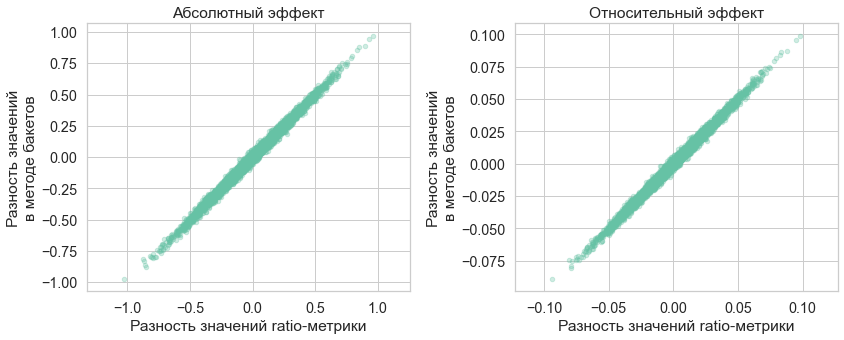

20 бакетов: 


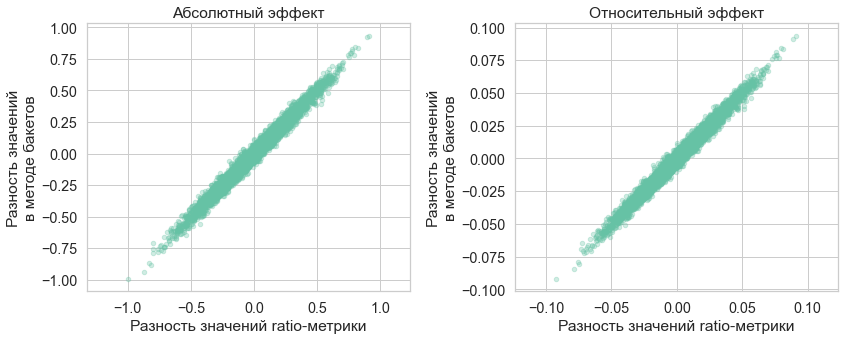

30 бакетов: 


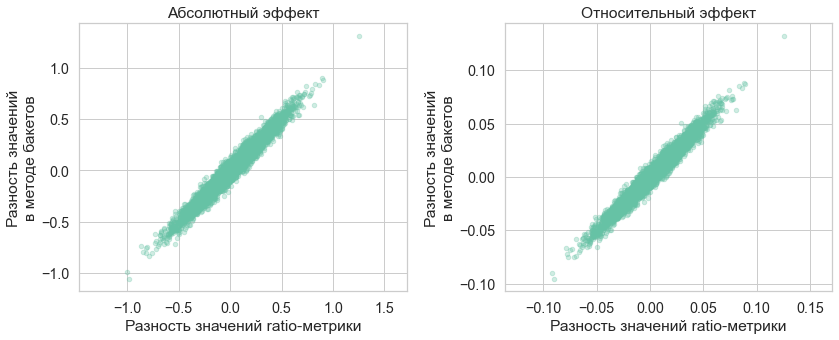

50 бакетов: 


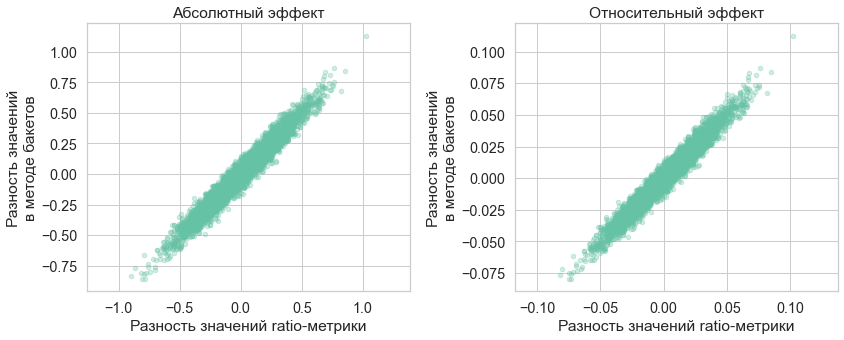

In [28]:
for j in range(4):
    print([10,20,30,50][j], 'бакетов: ')
    plt.figure(figsize=(12, 5))
    for i, value, title in zip(
        [1, 2],
        [str1[j], str2[j]],
        ['Абсолютный эффект', 'Относительный эффект']
    ):
        plt.subplot(1, 2, i)
        plt.scatter(value[0], value[1], s=20, alpha=0.3)
        plt.xlabel('Разность значений ratio-метрики')
        plt.ylabel('Разность значений\nв методе бакетов')
        plt.title(title)
        plt.axis('equal')

    plt.tight_layout()
    plt.show()

В каком случае можно говорить о приближенной сонаправленности?

Визуально оптимальнее всего вышло для 10 бакетов: самый маленький разброс вблизи нуля. Так и говорилось на лекции, что чем меньше бакетов, тем лучше сонаправленность, но хуже помогает cuped.

**2.** Давай все же попробуем сделать CUPED в методе бакетов, может нам зря рассказывали про линеаризацию...

Для начала внедрим CUPED в метод бакетов. Не забудь, что CUPED-преобразование необходимо применять непосредственно к бакетам, а не к исходным пользователям.

*Подсказка.* При определении бакетов удобно сделать группировку по двум полям сразу &mdash; по номеру бакета и по номеру периода. Далее надо будет смерджить горизонтально две части таблицы по периодам, то есть каждый бакет должен быть представлен только одной строкой, в которой будут данные за оба периода.

In [11]:
def generate_session_sample(
    n_users=100, mean_session_count=15, effect=0
):
    '''
    Генерация данных пользовательских сессий для двух последовательных периодов.
    
    n_users -- количество пользователей
    mean_session_count -- среднее количество сессий на пользователя
    effect -- добавляемый эффект
    '''
    
    # Параметр формы гамма-распределения для каждого пользователя
    user_parameters = np.random.uniform(size=n_users, low=1, high=20)
    
    # Количество сессий каждого пользователя.
    # Генерируем в два раза больше, чтобы хватило на два периода.
    user_session_counts = 2 + np.random.poisson(
        size=n_users, lam=2*mean_session_count
    )
    
    users = []
    period = []
    session_lengths = []
    
    # Для каждого пользователя генерируем все его сессии
    for user_id in range(n_users):
        users += [f'id_{user_id}'] * user_session_counts[user_id]
        session_lengths += list(np.random.gamma(
            shape=user_parameters[user_id], 
            size=user_session_counts[user_id]
        ) + effect)
        
        # В предположении, что все сессии равномерно распределены во времени,
        # количество сессий в каждом периоде имеет биномиальное распределение 
        # с параметрами n=кол-во сессий и p=1/2.
        count = np.random.binomial(n=user_session_counts[user_id], p=0.5)
        
        # Исключаем случаи, когда в одном из периодов нет сессий
        count = min(max(1, count), user_session_counts[user_id]-1)
        
        # Определяем периоды
        period += [1] * count 
        period += [0] * (user_session_counts[user_id] - count)
        
    # Заносим в табличку
    data = pd.DataFrame({
        'user_id': users,
        'session_lengths': np.array(session_lengths, dtype=float),
        'period': np.array(period, dtype=int)
    })
        
    return data

In [48]:
data = generate_session_sample(n_users=5, mean_session_count=5)
data.head(10)

,user_id,session_lengths,period
0,id_0,9.229392,1
1,id_0,7.506863,0
2,id_0,7.806776,0
3,id_0,10.019159,0
4,id_0,12.767895,0
5,id_0,7.630537,0
6,id_0,8.752044,0
7,id_0,6.861320,0
8,id_1,2.216722,1
9,id_1,3.729590,1


In [12]:
def bucket_transform(
    data, numerator_name, user_name='user_id', 
    denominator_name=None, num_buckets=10
):
    '''
    Создает бакеты из данных.
    
    data -- таблица данных
    numerator_name -- имя колонки-числителя ratio-метрики
    user_name -- имя колонки с id пользователей
    denominator_name -- имя колонки-знаменателя ratio-метрики
    num_buckets -- число бакетов
    
    Возвращает сгруппированные данные
    '''
    
    if denominator_name is None:
        denominator_name = 'ratio_denominator'
        data[denominator_name] = 1

    data['bucket'] = data[user_name].apply(lambda x: np.abs(hash(x)) % num_buckets)
    groupped_data = data.groupby(by=['bucket', 'period'])[[numerator_name, denominator_name]].sum()
    groupped_data['values'] = groupped_data[numerator_name] / groupped_data[denominator_name]
    answ = pd.concat((groupped_data.iloc[::2], 
                      groupped_data.iloc[1::2].set_index(groupped_data.iloc[::2].index)), 
                     axis = 1).set_index(np.arange(len(groupped_data) // 2))
    answ.columns = ["session_lengths", "ratio_denominator", "values", "session_lengths_1", "ratio_denominator_1", "values_1"]
    return answ

In [57]:
bucket_transform(data, numerator_name='session_lengths')

,session_lengths,ratio_denominator,values,session_lengths_1,ratio_denominator_1,values_1
0,207.072813,10,20.707281,64.423312,3,21.474437
1,65.434109,4,16.358527,112.856260,5,22.571252
2,86.011731,15,5.734115,38.889009,12,3.240751
3,78.318928,6,13.053155,62.527233,5,12.505447


In [13]:
def generate_transform(
    n_users=100, mean_session_count=15, 
    num_buckets=10, effect=0
):
    '''
    Функция, объединяющая генерацию данных и их бакет-преобразование.
    
    n_users -- количество пользователей
    mean_session_count -- среднее количество сессий на пользователя
    num_buckets -- число бакетов
    effect -- добавляемый эффект
    '''
    
    data = generate_session_sample(
        n_users=n_users, mean_session_count=mean_session_count, effect=effect
    )
    return bucket_transform(
        data, 
        numerator_name='session_lengths', 
        num_buckets=num_buckets
    )

In [85]:
generate_transform(n_users=5, num_buckets=num_buckets)

,session_lengths,ratio_denominator,values,session_lengths_1,ratio_denominator_1,values_1
0,580.431031,35,16.583744,580.024182,37,15.676329
1,97.868132,11,8.897103,113.221909,14,8.087279
2,194.928645,18,10.829369,173.784983,16,10.861561
3,359.765161,21,17.131674,187.775895,10,18.777590


In [14]:
def cuped_transform(
    x_data, y_data, 
    sample_name='pilot', cuped_name='cuped', covariate_name='prepilot', 
    paired=False, return_theta=False
):
    '''
    Выполняет CUPED-преобразование.
    
    :param x_data: данные тестовой группы
    :param y_data: данные контрольной группы
    :param sample_name: имя столбца с целевым признаком
    :param cuped_name: имя столбца, в который записать преобразование
    :param covariate_name: имя столбца-ковариаты
    :param paired: являются ли выборки парными
    :param return_theta: возвращать ли значение theta
    :return: таблицы с добавленными столбцами и theta
    '''
    
    # Случай парных выборок
    if paired:
        theta = (
            np.cov(
                x_data[covariate_name]-y_data[covariate_name], 
                x_data[sample_name]-y_data[sample_name]
            )[0, 1]
        ) / (
            (x_data[covariate_name] - y_data[covariate_name]).var(ddof=0)
        )

    # Случай независимых выборок
    else:
        theta = (
            np.cov(x_data[covariate_name], x_data[sample_name])[0, 1] \
            + np.cov(y_data[covariate_name], y_data[sample_name])[0, 1]
        ) / (
            x_data[covariate_name].var(ddof=0) + y_data[covariate_name].var(ddof=0)
        )
    
    # Делаем преобразование
    x_data[cuped_name] = x_data[sample_name] - theta*x_data[covariate_name]
    y_data[cuped_name] = y_data[sample_name] - theta*y_data[covariate_name]
    
    if return_theta:
        return x_data, y_data, theta
    else:
        return x_data, y_data

In [15]:
def cuped_ttest(x_data, y_data, alpha=0.05):
    '''
    Абсолютный t-test.
    
    :param x_data: выборка вместе с информацией о cuped-преобразовании
    :param y_data: выборка вместе с информацией о cuped-преобразовании
    :param alpha: уровень значимости
    :return: статистика критерия, p-value
    '''
    
    x_data, y_data = cuped_transform(x_data, y_data, sample_name='values', cuped_name='cuped', covariate_name='values_1')
    return sps.ttest_ind(x_data['cuped'], y_data['cuped'])

Теперь провалидируем применение CUPED в методе бакетов на предмет контролирования ошибки 1 рода. Как и раньше, бери какую-нибудь функцию AA-теста с занятия.

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [10:25<00:00,  7.99it/s]


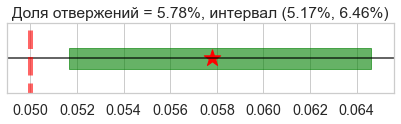

In [77]:
num_buckets = 10
effect = 0
AA_test(
        test=lambda x, y: cuped_ttest(x, y)[1] < alpha,
        generate_sample_x=lambda size: generate_transform(n_users=size, num_buckets=num_buckets),
        sample_size=sample_size,
        n_iter=n_iter, 
        effect=effect,
        feature_values='values'
    )

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [10:33<00:00,  7.89it/s]


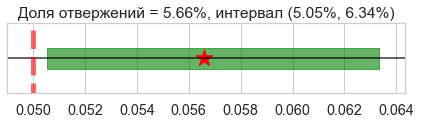

In [78]:
num_buckets = 20
effect = 0
AA_test(
        test=lambda x, y: cuped_ttest(x, y)[1] < alpha,
        generate_sample_x=lambda size: generate_transform(n_users=size, num_buckets=num_buckets),
        sample_size=sample_size,
        n_iter=n_iter, 
        effect=effect,
        feature_values='values'
    )

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [10:36<00:00,  7.86it/s]


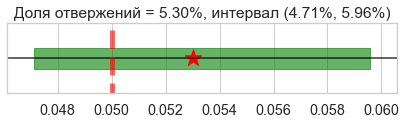

In [79]:
num_buckets = 30
effect = 0
AA_test(
        test=lambda x, y: cuped_ttest(x, y)[1] < alpha,
        generate_sample_x=lambda size: generate_transform(n_users=size, num_buckets=num_buckets),
        sample_size=sample_size,
        n_iter=n_iter, 
        effect=effect,
        feature_values='values'
    )

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [10:11<00:00,  8.18it/s]


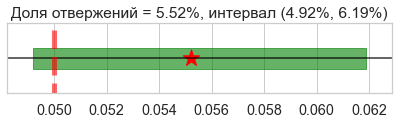

In [80]:
num_buckets = 50
effect = 0
AA_test(
        test=lambda x, y: cuped_ttest(x, y)[1] < alpha,
        generate_sample_x=lambda size: generate_transform(n_users=size, num_buckets=num_buckets),
        sample_size=sample_size,
        n_iter=n_iter, 
        effect=effect,
        feature_values='values'
    )

Для какого количества бакетов выполнены одновременно первые два условия?

Не очень понял, что за первые два условия, но, видимо, это про сонаправленность и ошибку первого рода. Для 10 бакетов ошибка первого рода великовата, а для 50 сонапраленности совсем нет, так что посмотрим мощность для 20 и 30 бакетов (хотя 20 бакетов не прошли проверку на ошибку первого рода, но на чуть-чуть)

**3.** Если такие случаи нашлись, оцени мощность соответствующих тестов для размеров эффекта от 1% до 5%. Сравни ее с CUPED в методе линеаризации.

*Хм, кажется, или здесь тоже только код позапускать?*

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [10:21<00:00,  8.05it/s]


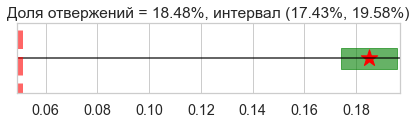

In [81]:
num_buckets = 20
effect = 0.01
AA_test(
        test=lambda x, y: cuped_ttest(x, y)[1] < alpha,
        generate_sample_x=lambda size: generate_transform(n_users=size, num_buckets=num_buckets),
        sample_size=sample_size,
        n_iter=n_iter, 
        effect=effect,
        feature_values='values'
    )

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [10:16<00:00,  8.10it/s]


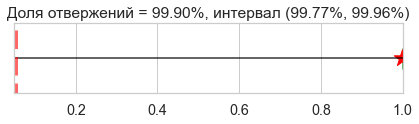

In [82]:
num_buckets = 20
effect = 0.05
AA_test(
        test=lambda x, y: cuped_ttest(x, y)[1] < alpha,
        generate_sample_x=lambda size: generate_transform(n_users=size, num_buckets=num_buckets),
        sample_size=sample_size,
        n_iter=n_iter, 
        effect=effect,
        feature_values='values'
    )

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [10:11<00:00,  8.18it/s]


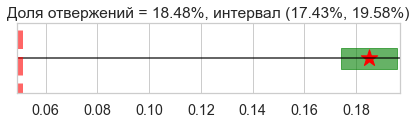

In [83]:
num_buckets = 30
effect = 0.01
AA_test(
        test=lambda x, y: cuped_ttest(x, y)[1] < alpha,
        generate_sample_x=lambda size: generate_transform(n_users=size, num_buckets=num_buckets),
        sample_size=sample_size,
        n_iter=n_iter, 
        effect=effect,
        feature_values='values'
    )

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [10:06<00:00,  8.24it/s]


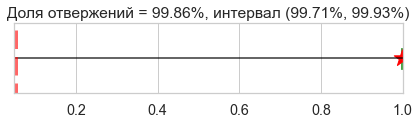

In [84]:
num_buckets = 30
effect = 0.05
AA_test(
        test=lambda x, y: cuped_ttest(x, y)[1] < alpha,
        generate_sample_x=lambda size: generate_transform(n_users=size, num_buckets=num_buckets),
        sample_size=sample_size,
        n_iter=n_iter, 
        effect=effect,
        feature_values='values'
    )

**Выводы:** Разница в статистической погрешности. Но для меньшего/большего количества бакетов мы бы скорее всего заметили разницу в мощности, как это было в случае с нулевым эффектом. Итого в методе бакетов надо правильно подбирать количество корзин, чтобы была сонаправленность (мало корзин), а также проходилась проверка на ошибку первого рода (много корзин), то есть надо брать какое-то среднее значение бакетов.

Вот и первая задачка закончилась! Правда же простая и интересная задачка?)

**Ответ:** Метод бакетов неплохо себя показал, но все же он похуже линеаризации

---
### Задача 2

Отлично, впереди все самое интересное &mdash; реальные данные! Вам выдана часть информации о визитах пользователей на <a href="https://miptstats.github.io/">сайте</a> Физтех.Статистики по данным Яндекс.Метрики. Ранее адрес сайта был другим. Визит &mdash; последовательность действий пользователя на сайте, которая начинается на некоторой странице сайта, содержит в себе переходы по ссылкам (и другие действия), и заканчивается на какой-то, возможно, другой страницей сайта. Визит считается завершенным, если активность отсутствует в течение некоторого времени, обычно &mdash; 30 минут.

Описание полей доступно по <a href="https://yandex.ru/dev/metrika/doc/api2/logs/fields/visits.html">ссылке</a>.

**1.** Ознакомься с данными, ответив на следующие вопросы.
1. Сколько всего визитов представлено в данных?
2. Когда совершены первый и последний визиты?
3. Постройте динамику количества визитов во времени по дням.
4. Сколько уникальных пользователей в данных?
5. Сколько в среднем один пользователь совершил визитов? Сколько максимально?
6. Постройте гистограмму глубины и продолжительности визитов.
7. Из каких стран больше пользователей?
8. Какие браузеры и операционные системы в топе?

In [16]:
data = pd.read_excel('hw_ysda_ab7_data.xlsx')
data.head()

,Unnamed: 0,ym:s:dateTimeUTC,ym:s:clientID,ym:s:isNewUser,ym:s:startURL,ym:s:endURL,ym:s:pageViews,ym:s:visitDuration,ym:s:regionCountry,ym:s:operatingSystemRoot,ym:s:browser
0,0,2022-05-31 23:56:16,1654030577712417024,1,https://mipt-stats.gitlab.io/,https://mipt-stats.gitlab.io/,1,0,Russia,macos,safari
1,1,2022-05-31 23:56:08,1654030568881218048,1,https://mipt-stats.gitlab.io/courses/python/04...,https://mipt-stats.gitlab.io/courses/python/04...,2,862,Georgia,ios_double,safari_mobile
2,2,2022-05-31 23:53:14,1646837295118768128,0,https://mipt-stats.gitlab.io/courses/ad_fivt/t...,https://mipt-stats.gitlab.io/courses/ad_fivt/t...,1,17,Russia,windows,opera
3,3,2022-05-31 23:37:47,1654029468423538944,1,https://mipt-stats.gitlab.io/courses/python/01...,https://mipt-stats.gitlab.io/courses/python/01...,2,62,Russia,windows,yandex_browser
4,4,2022-05-31 23:35:58,1654029359126554880,1,https://mipt-stats.gitlab.io/courses/python/08...,https://mipt-stats.gitlab.io/courses/python/08...,1,15,Netherlands,windows,chrome


In [88]:
data.shape

(85573, 11)

85573 визитов у нас всего

In [94]:
data['ym:s:dateTimeUTC'].apply(lambda x: x[0:4]).value_counts()

2022    61754
2021    23819
Name: ym:s:dateTimeUTC, dtype: int64

Данные за два года

In [17]:
data['info_about_date'] = data['ym:s:dateTimeUTC'].apply(lambda x: int(x[0:4] + x[5:7] + x[8:10]))
data.head()

,Unnamed: 0,ym:s:dateTimeUTC,ym:s:clientID,ym:s:isNewUser,ym:s:startURL,ym:s:endURL,ym:s:pageViews,ym:s:visitDuration,ym:s:regionCountry,ym:s:operatingSystemRoot,ym:s:browser,info_about_date
0,0,2022-05-31 23:56:16,1654030577712417024,1,https://mipt-stats.gitlab.io/,https://mipt-stats.gitlab.io/,1,0,Russia,macos,safari,20220531
1,1,2022-05-31 23:56:08,1654030568881218048,1,https://mipt-stats.gitlab.io/courses/python/04...,https://mipt-stats.gitlab.io/courses/python/04...,2,862,Georgia,ios_double,safari_mobile,20220531
2,2,2022-05-31 23:53:14,1646837295118768128,0,https://mipt-stats.gitlab.io/courses/ad_fivt/t...,https://mipt-stats.gitlab.io/courses/ad_fivt/t...,1,17,Russia,windows,opera,20220531
3,3,2022-05-31 23:37:47,1654029468423538944,1,https://mipt-stats.gitlab.io/courses/python/01...,https://mipt-stats.gitlab.io/courses/python/01...,2,62,Russia,windows,yandex_browser,20220531
4,4,2022-05-31 23:35:58,1654029359126554880,1,https://mipt-stats.gitlab.io/courses/python/08...,https://mipt-stats.gitlab.io/courses/python/08...,1,15,Netherlands,windows,chrome,20220531


In [103]:
data['info_about_date'].min(), data['info_about_date'].max()

(20210901, 20220531)

Первый визит был 2021-09-01, последний - 2022-05-31

In [121]:
len(data['ym:s:clientID'].value_counts())

41565

Из 85573 пользователей 41565 уникальных

In [112]:
data.groupby('ym:s:clientID')['ym:s:isNewUser'].count().mean()

2.058775412005293

В среднем по два визита для пользователя

In [113]:
data.groupby('ym:s:clientID')['ym:s:isNewUser'].count().max()

218

Один невероятно активный пользователь умудрился совершить аж 218 визитов на сайт

In [123]:
data['ym:s:regionCountry'].value_counts()[:5]

Russia        80146
Belarus        1199
Kazakhstan      923
Ukraine         361
Germany         355
Name: ym:s:regionCountry, dtype: int64

Топ 5 стран, откуда посещали данный сайт

In [124]:
data['ym:s:browser'].value_counts()[:5]

chrome            34614
yandex_browser    18082
opera              6477
firefox            6270
edge               5511
Name: ym:s:browser, dtype: int64

In [125]:
data['ym:s:operatingSystemRoot'].value_counts()[:5]

windows       57248
gnu_linux      8840
macos          8123
android        7518
ios_double     3759
Name: ym:s:operatingSystemRoot, dtype: int64

Топ браузеров и операционных систем. В основном все заходят с windows, google chrome

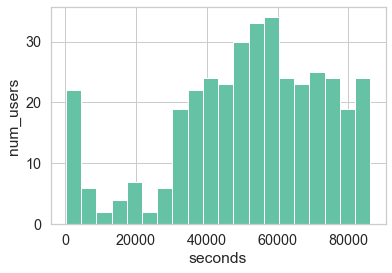

In [132]:
date = 20220531
time_in_seconds = data[data['info_about_date'] == date]['ym:s:dateTimeUTC'].apply(lambda x: 
                                                                   int(x[11:13]) * 3600 + int(x[14:16]) * 60 + int(x[17:19]))
plt.hist(time_in_seconds, bins = 20)
plt.xlabel('seconds')
plt.ylabel('num_users')
plt.show()

В течение дня активность падает ночью и при этом она более менее равномерная днем с выделяющимся пиком в 15 часов

In [145]:
len(data[data['ym:s:pageViews'] > 10])

2053

Мало пользователей посетили больше 10 страниц. Выкинем эти выбросы, чтобы было приятно смотреть на гистограмму

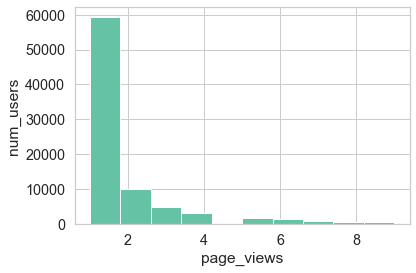

In [148]:
plt.hist(data[data['ym:s:pageViews'] < 10]['ym:s:pageViews'])
plt.xlabel('page_views')
plt.ylabel('num_users')
plt.show()

Почти у всех глубина единичка

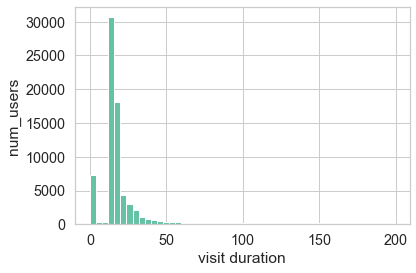

In [163]:
plt.hist(data[data['ym:s:visitDuration'] < 200]['ym:s:visitDuration'], bins = 50)
plt.xlabel('visit duration')
plt.ylabel('num_users')
plt.show()

Продолжительность в основном колеблется между 0 и 50

**2.** В мае команда Физтех.Статистики планирует провести эксперимент, покрасив фон всех страниц в розовый цвет, а также добавив к нему анимированных котиков и сердечек. *Гипотеза &mdash; средняя продолжительность визитов вырастет на 10%, а средняя глубина просмотров также вырастет на 10%.* 

Поясни, почему эти метрики являются ratio-метриками, и укажи, что в числителе, а что в знаменателе.

В обоих случаях в числителе у нас будет сумма признака по пользователям (то есть X_1 - это сумма продолжительностей визитов (или глубин визитов) пользователя 1 и т.д). В знаменателе количество визитов конкретного пользователя. Это ratio метрики, так как у нас в числителе и в знаменателе случайные величины. При этом мы вычисляем среднюю продолжительность (среднюю глубину) по визитам

**3.** Давай проверим сонаправленность на реальных данных для разных подходов. Проверку нужно выполнить аналогично AA-тесту, совершая следующие итерации.
1. Выбрать случайный интервал времени фиксированной длины в истории визитов.
2. Выбрать две случайные группы фиксированного размера.
3. Посчитать по ним ratio-метрику и исследуемую метрику.

*Правда ведь просто? Ну разве что выбор момента времени и группы надо дописать.*

Проведи эту проверку для длительности и глубины (можно в одном цикле) для следующих подходов:
- агрегация данных по пользователям,
- метод бакетов,
- линеаризация.

Все эти способы рассматривались на занятии, так что это еще один повод туда заглянуть. Напомним, ratio-метрика считается как общее отношение, без агрегации по пользователям.

Выполни всю эту процедуру для двух разных размеров групп и двух разных длин интервалов. Например, 10% и 20% пользователей, а так же 3 и 5 недель.

In [18]:
dct = {}
for i in range(1, 13):
    if i < 8:
        if i % 2 == 1:
            dct[i] = 31
        elif i == 2:
            dct[i] = 28
        elif i % 2 == 0:
            dct[i] = 30
    else:
        if i % 2 == 0:
            dct[i] = 31
        elif i % 2 == 1:
            dct[i] = 30
dct # сколько дней в каждом месяце

{1: 31,
 2: 28,
 3: 31,
 4: 30,
 5: 31,
 6: 30,
 7: 31,
 8: 31,
 9: 30,
 10: 31,
 11: 30,
 12: 31}

In [19]:
dct1 = {}
suma = 0
for i in range(12):
    dct1[i + 1] = suma + dct[i + 1]
    suma += dct[i + 1]
dct1

{1: 31,
 2: 59,
 3: 90,
 4: 120,
 5: 151,
 6: 181,
 7: 212,
 8: 243,
 9: 273,
 10: 304,
 11: 334,
 12: 365}

In [20]:
data['info_about_date'] = data['ym:s:dateTimeUTC'].apply(lambda x: int(x[0:4]) * 365 + dct1[int(x[5:7])] - 
                                                         dct[int(x[5:7])] + int(x[8:10]))
data.head()

,Unnamed: 0,ym:s:dateTimeUTC,ym:s:clientID,ym:s:isNewUser,ym:s:startURL,ym:s:endURL,ym:s:pageViews,ym:s:visitDuration,ym:s:regionCountry,ym:s:operatingSystemRoot,ym:s:browser,info_about_date
0,0,2022-05-31 23:56:16,1654030577712417024,1,https://mipt-stats.gitlab.io/,https://mipt-stats.gitlab.io/,1,0,Russia,macos,safari,738181
1,1,2022-05-31 23:56:08,1654030568881218048,1,https://mipt-stats.gitlab.io/courses/python/04...,https://mipt-stats.gitlab.io/courses/python/04...,2,862,Georgia,ios_double,safari_mobile,738181
2,2,2022-05-31 23:53:14,1646837295118768128,0,https://mipt-stats.gitlab.io/courses/ad_fivt/t...,https://mipt-stats.gitlab.io/courses/ad_fivt/t...,1,17,Russia,windows,opera,738181
3,3,2022-05-31 23:37:47,1654029468423538944,1,https://mipt-stats.gitlab.io/courses/python/01...,https://mipt-stats.gitlab.io/courses/python/01...,2,62,Russia,windows,yandex_browser,738181
4,4,2022-05-31 23:35:58,1654029359126554880,1,https://mipt-stats.gitlab.io/courses/python/08...,https://mipt-stats.gitlab.io/courses/python/08...,1,15,Netherlands,windows,chrome,738181


In [174]:
data['info_about_date'].min(), data['info_about_date'].max()

(737909, 738181)

С такой обработкой даты нам будет удобнее работать

Агрегация по пользователям:

In [182]:
def generate_users_data(
    ratio_users=0.1, weeks=3
):
    
    start = int(np.random.randint(737909, 738181 - weeks * 7 + 1, 1))
    data1 = data[data['info_about_date'] <= start + weeks * 7]
    data1 = data1[start <= data1['info_about_date']]
    data1 = data1.set_index(np.arange(len(data1)))
    indices = np.random.choice(len(np.unique(data1['ym:s:clientID'])), 
                               int(ratio_users * len(np.unique(data1['ym:s:clientID'])))) 
    users_x = data1.groupby('ym:s:clientID').mean().index[indices[:len(indices) // 2]]
    users_y = data1.groupby('ym:s:clientID').mean().index[indices[len(indices) // 2:]]
    
    data1['x'] = data1['ym:s:clientID'].apply(lambda x: x in list(users_x))
    data1['y'] = data1['ym:s:clientID'].apply(lambda x: x in list(users_y))

    return data1[data1['x']], data1[data1['y']]

In [183]:
def ratio_metric(data, numerator_name, denominator_name=None):
    '''
    Вычисляет ratio-метрику
    
    data -- таблица данных
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    '''
    
    if denominator_name is None:
        return data[numerator_name].mean()
    else:
        
        return data[numerator_name].sum() / data[denominator_name].sum()


def users_mean_metric(
    data, numerator_name, user_name='ym:s:clientID', denominator_name=None
):
    '''
    Вычисляет метрики отдельно по пользователям
    
    data -- данные
    numerator_name -- имя колонки-числителя ratio-метрики
    user_name -- имя колонки с id пользователей
    denominator_name -- имя колонки-знаменателя ratio-метрики
    '''
    
    groupped_data = data.groupby(user_name)
    
    if denominator_name is None:
        return groupped_data.mean()[numerator_name].mean()
    else:
        users_values = groupped_data[numerator_name].sum() \
            / groupped_data[denominator_name].sum()
        return users_values.mean()

In [184]:
def metric_sampler(
    generate_sample, metrics, target_name, 
    n_iter=10000, ratio_users=0.1, weeks = 3
):
    '''
    Генерация значений разности средних по группам для разных метрик.
    
    Аргументы:
    generate_sample -- функции для семплирования выборок
    metrics -- список метрик
    target_name -- поле для вычисления метрики
    n_iter -- количество итераций
    sample_size -- размер выборок
    '''

    values_absolute = np.zeros((len(metrics), n_iter))
    values_relative = np.zeros((len(metrics), n_iter))

    # Проведение экспериментов
    for i in tqdm(range(n_iter)):
        x, y = generate_users_data(ratio_users, weeks)
        for j, metric in enumerate(metrics):
            test = metric(x, target_name)
            control = metric(y, target_name)
            values_absolute[j, i] = test - control
            values_relative[j, i] = (test - control) / control

    return values_absolute, values_relative

In [27]:
ratio_users = 0.1
weeks = 3
target_name = "ym:s:pageViews"

values_absolute, values_relative = metric_sampler(
    generate_users_data, 
    metrics=[ratio_metric, users_mean_metric], 
    target_name=target_name, 
    n_iter=n_iter, 
    ratio_users=ratio_users,
    weeks = weeks
)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [22:24<00:00,  3.72it/s]


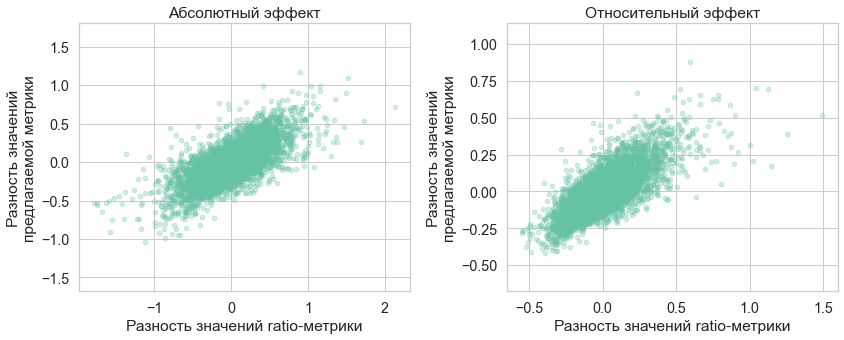

In [28]:
plt.figure(figsize=(12, 5))
for i, value, title in zip(
    [1, 2],
    [values_absolute, values_relative],
    ['Абсолютный эффект', 'Относительный эффект']
):
    plt.subplot(1, 2, i)
    plt.scatter(value[0], value[1], s=20, alpha=0.3)
    plt.xlabel('Разность значений ratio-метрики')
    plt.ylabel('Разность значений\nпредлагаемой метрики')
    plt.title(title)
    plt.axis('equal')
    
plt.tight_layout()

Кошмар, ужас. Никакой сонапраленности

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:10:12<00:00,  1.19it/s]


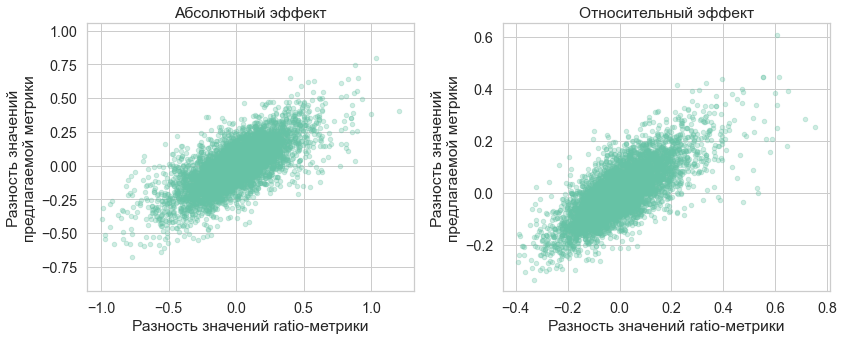

In [185]:
ratio_users = 0.2
weeks = 3
target_name = "ym:s:pageViews"

values_absolute, values_relative = metric_sampler(
    generate_users_data, 
    metrics=[ratio_metric, users_mean_metric], 
    target_name=target_name, 
    n_iter=n_iter, 
    ratio_users=ratio_users,
    weeks = weeks
)

plt.figure(figsize=(12, 5))
for i, value, title in zip(
    [1, 2],
    [values_absolute, values_relative],
    ['Абсолютный эффект', 'Относительный эффект']
):
    plt.subplot(1, 2, i)
    plt.scatter(value[0], value[1], s=20, alpha=0.3)
    plt.xlabel('Разность значений ratio-метрики')
    plt.ylabel('Разность значений\nпредлагаемой метрики')
    plt.title(title)
    plt.axis('equal')
    
plt.tight_layout()

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:25:46<00:00,  1.03s/it]


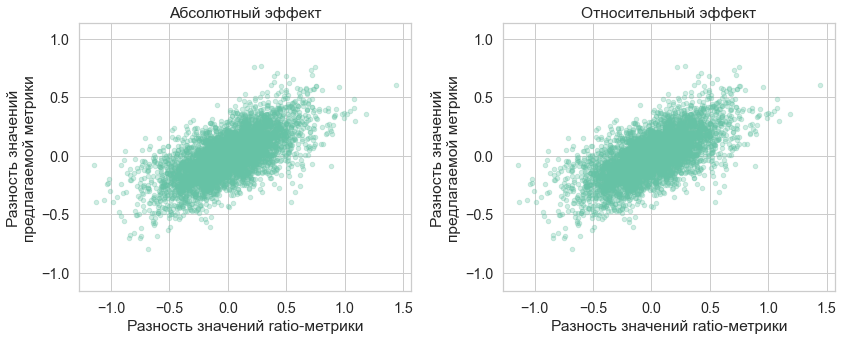

In [187]:
ratio_users = 0.1
weeks = 5
target_name = "ym:s:pageViews"

values_absolute, values_relative = metric_sampler(
    generate_users_data, 
    metrics=[ratio_metric, users_mean_metric], 
    target_name=target_name, 
    n_iter=n_iter, 
    ratio_users=ratio_users,
    weeks = weeks
)

plt.figure(figsize=(12, 5))
for i, value, title in zip(
    [1, 2],
    [value, value],
    ['Абсолютный эффект', 'Относительный эффект']
):
    plt.subplot(1, 2, i)
    plt.scatter(values_absolute[0], values_absolute[1], s=20, alpha=0.3)
    plt.xlabel('Разность значений ratio-метрики')
    plt.ylabel('Разность значений\nпредлагаемой метрики')
    plt.title(title)
    plt.axis('equal')
    
plt.tight_layout()

Для 20% пользователей и 5 недель не стал, так как и так код работает долго. Перейдем к следующему таргету:

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [26:51<00:00,  3.10it/s]


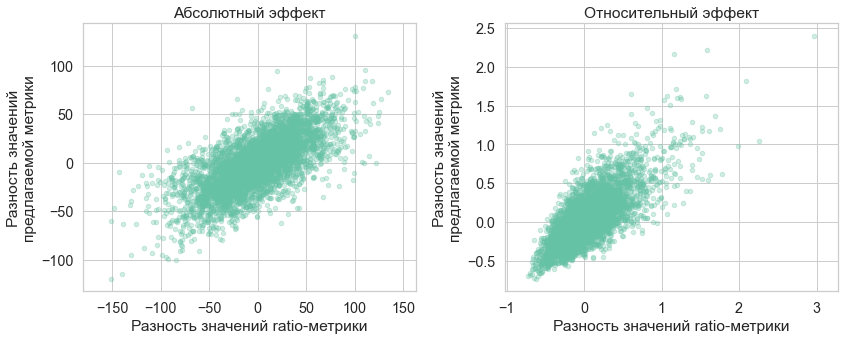

In [188]:
ratio_users = 0.1
weeks = 3
target_name = "ym:s:visitDuration"

values_absolute, values_relative = metric_sampler(
    generate_users_data, 
    metrics=[ratio_metric, users_mean_metric], 
    target_name=target_name, 
    n_iter=n_iter, 
    ratio_users=ratio_users,
    weeks = weeks
)

plt.figure(figsize=(12, 5))
for i, value, title in zip(
    [1, 2],
    [values_absolute, values_relative],
    ['Абсолютный эффект', 'Относительный эффект']
):
    plt.subplot(1, 2, i)
    plt.scatter(value[0], value[1], s=20, alpha=0.3)
    plt.xlabel('Разность значений ratio-метрики')
    plt.ylabel('Разность значений\nпредлагаемой метрики')
    plt.title(title)
    plt.axis('equal')
    
plt.tight_layout()

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [39:28<00:00,  2.11it/s]


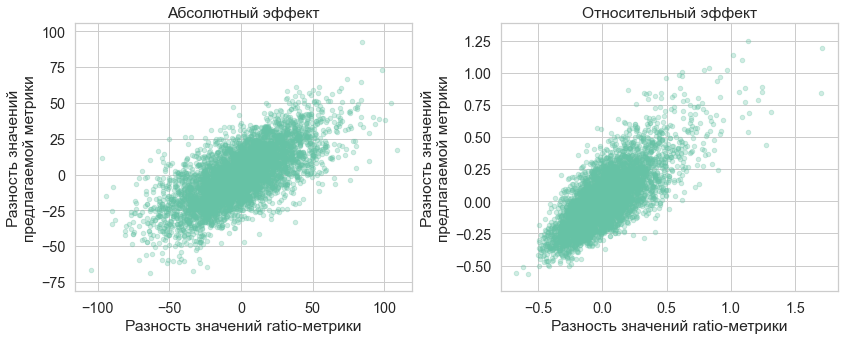

In [189]:
ratio_users = 0.2
weeks = 3
target_name = "ym:s:visitDuration"

values_absolute, values_relative = metric_sampler(
    generate_users_data, 
    metrics=[ratio_metric, users_mean_metric], 
    target_name=target_name, 
    n_iter=n_iter, 
    ratio_users=ratio_users,
    weeks = weeks
)

plt.figure(figsize=(12, 5))
for i, value, title in zip(
    [1, 2],
    [values_absolute, values_relative],
    ['Абсолютный эффект', 'Относительный эффект']
):
    plt.subplot(1, 2, i)
    plt.scatter(value[0], value[1], s=20, alpha=0.3)
    plt.xlabel('Разность значений ratio-метрики')
    plt.ylabel('Разность значений\nпредлагаемой метрики')
    plt.title(title)
    plt.axis('equal')
    
plt.tight_layout()

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [50:16<00:00,  1.66it/s]


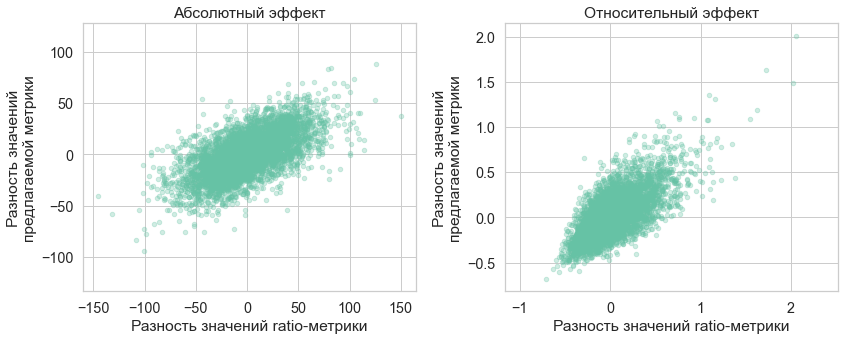

In [190]:
ratio_users = 0.1
weeks = 5
target_name = "ym:s:visitDuration"

values_absolute, values_relative = metric_sampler(
    generate_users_data, 
    metrics=[ratio_metric, users_mean_metric], 
    target_name=target_name, 
    n_iter=n_iter, 
    ratio_users=ratio_users,
    weeks = weeks
)

plt.figure(figsize=(12, 5))
for i, value, title in zip(
    [1, 2],
    [values_absolute, values_relative],
    ['Абсолютный эффект', 'Относительный эффект']
):
    plt.subplot(1, 2, i)
    plt.scatter(value[0], value[1], s=20, alpha=0.3)
    plt.xlabel('Разность значений ratio-метрики')
    plt.ylabel('Разность значений\nпредлагаемой метрики')
    plt.title(title)
    plt.axis('equal')
    
plt.tight_layout()

В целом здесь везде видно, что сонаправленности на таких данных нету

Метод бакетов:

In [191]:
def bucket_transform(
    data, numerator_name, user_name='ym:s:clientID', 
    denominator_name=None, num_buckets=10
):
    '''
    Создает бакеты из данных.
    
    data -- таблица данных
    numerator_name -- имя колонки-числителя ratio-метрики
    user_name -- имя колонки с id пользователей
    denominator_name -- имя колонки-знаменателя ratio-метрики
    num_buckets -- число бакетов
    
    Возвращает сгруппированные данные
    '''
    
    if denominator_name is None:
        denominator_name = 'ratio_denominator'
        data[denominator_name] = 1

    data['bucket'] = data[user_name].apply(lambda x: np.abs(hash(x)) % num_buckets)
    groupped_data = data.groupby(by='bucket')[[numerator_name, denominator_name]].sum()
    groupped_data['values'] = groupped_data[numerator_name] / groupped_data[denominator_name]
    return groupped_data

In [192]:
def bucket_metric(
    data, numerator_name, user_name='ym:s:clientID', denominator_name=None, num_buckets=10
):
    '''
    Вычисляет метрики отдельно по бакетам
    
    data -- данные
    numerator_name -- имя колонки-числителя ratio-метрики
    user_name -- имя колонки с id пользователей
    denominator_name -- имя колонки-знаменателя ratio-метрики
    '''
    
    bucket_data = bucket_transform(
        data, numerator_name, user_name=user_name, 
        denominator_name=denominator_name, num_buckets=num_buckets
    )
    
    return bucket_data['values'].mean()

In [193]:
def metric_sampler(
    generate_sample, metrics, target_name, 
    n_iter=10000, ratio_users=0.1, weeks = 3
):
    '''
    Генерация значений разности средних по группам для разных метрик.
    
    Аргументы:
    generate_sample -- функции для семплирования выборок
    metrics -- список метрик
    target_name -- поле для вычисления метрики
    n_iter -- количество итераций
    sample_size -- размер выборок
    '''

    values_absolute = np.zeros((len(metrics), n_iter))
    values_relative = np.zeros((len(metrics), n_iter))

    # Проведение экспериментов
    for i in tqdm(range(n_iter)):
        x, y = generate_users_data(ratio_users, weeks)
        
        for j, metric in enumerate(metrics):
            test = metric(x, target_name)
            control = metric(y, target_name)
            values_absolute[j, i] = test - control
            values_relative[j, i] = (test - control) / control

    return values_absolute, values_relative

In [35]:
ratio_users = 0.1
weeks = 3
target_name = "ym:s:pageViews"

values_absolute, values_relative = metric_sampler(
    generate_users_data, 
    metrics=[ratio_metric, bucket_metric], 
    target_name=target_name, 
    n_iter=n_iter, 
    ratio_users=ratio_users,
    weeks = weeks
)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [21:46<00:00,  3.83it/s]


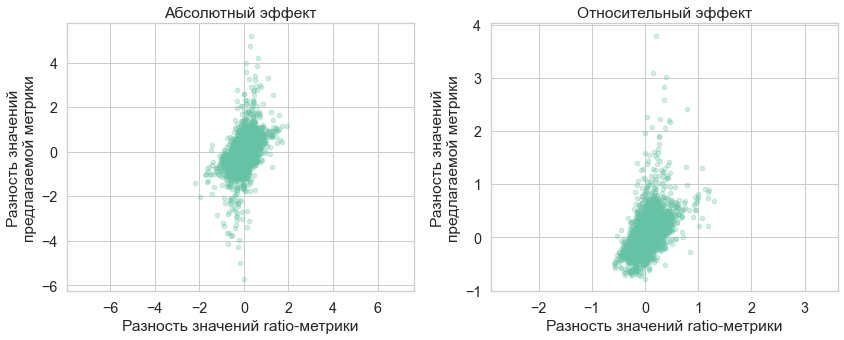

In [36]:
plt.figure(figsize=(12, 5))
for i, value, title in zip(
    [1, 2],
    [values_absolute, values_relative],
    ['Абсолютный эффект', 'Относительный эффект']
):
    plt.subplot(1, 2, i)
    plt.scatter(value[0], value[1], s=20, alpha=0.3)
    plt.xlabel('Разность значений ratio-метрики')
    plt.ylabel('Разность значений\nпредлагаемой метрики')
    plt.title(title)
    plt.axis('equal')
    
plt.tight_layout()

Тоже плохо вышло

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [39:58<00:00,  2.08it/s]


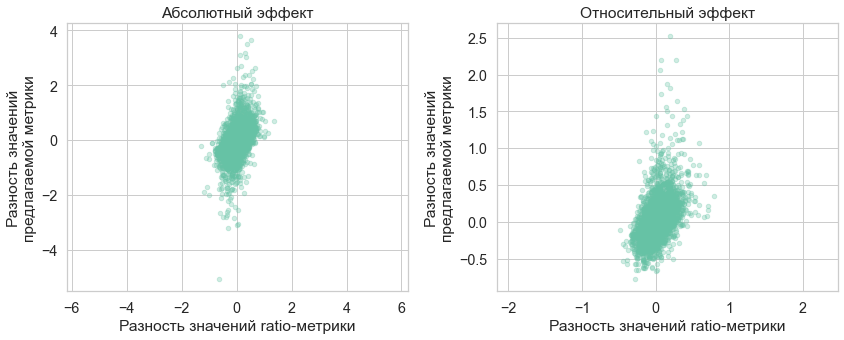

In [194]:
ratio_users = 0.2
weeks = 3
target_name = "ym:s:pageViews"

values_absolute, values_relative = metric_sampler(
    generate_users_data, 
    metrics=[ratio_metric, bucket_metric], 
    target_name=target_name, 
    n_iter=n_iter, 
    ratio_users=ratio_users,
    weeks = weeks
)

plt.figure(figsize=(12, 5))
for i, value, title in zip(
    [1, 2],
    [values_absolute, values_relative],
    ['Абсолютный эффект', 'Относительный эффект']
):
    plt.subplot(1, 2, i)
    plt.scatter(value[0], value[1], s=20, alpha=0.3)
    plt.xlabel('Разность значений ratio-метрики')
    plt.ylabel('Разность значений\nпредлагаемой метрики')
    plt.title(title)
    plt.axis('equal')
    
plt.tight_layout()

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [50:43<00:00,  1.64it/s]


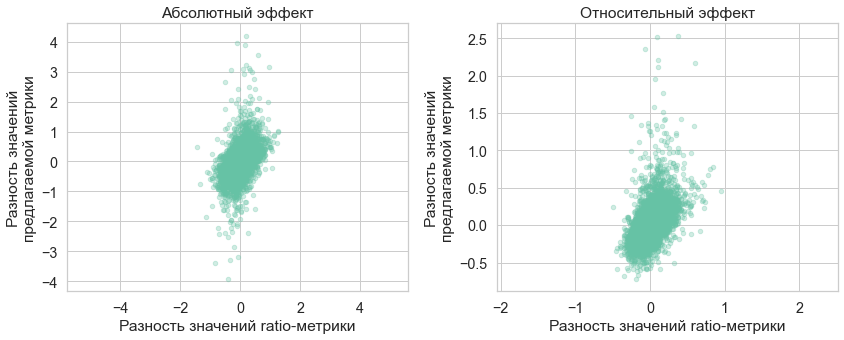

In [195]:
ratio_users = 0.1
weeks = 5
target_name = "ym:s:pageViews"

values_absolute, values_relative = metric_sampler(
    generate_users_data, 
    metrics=[ratio_metric, bucket_metric], 
    target_name=target_name, 
    n_iter=n_iter, 
    ratio_users=ratio_users,
    weeks = weeks
)

plt.figure(figsize=(12, 5))
for i, value, title in zip(
    [1, 2],
    [values_absolute, values_relative],
    ['Абсолютный эффект', 'Относительный эффект']
):
    plt.subplot(1, 2, i)
    plt.scatter(value[0], value[1], s=20, alpha=0.3)
    plt.xlabel('Разность значений ratio-метрики')
    plt.ylabel('Разность значений\nпредлагаемой метрики')
    plt.title(title)
    plt.axis('equal')
    
plt.tight_layout()

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [20:48<00:00,  4.00it/s]


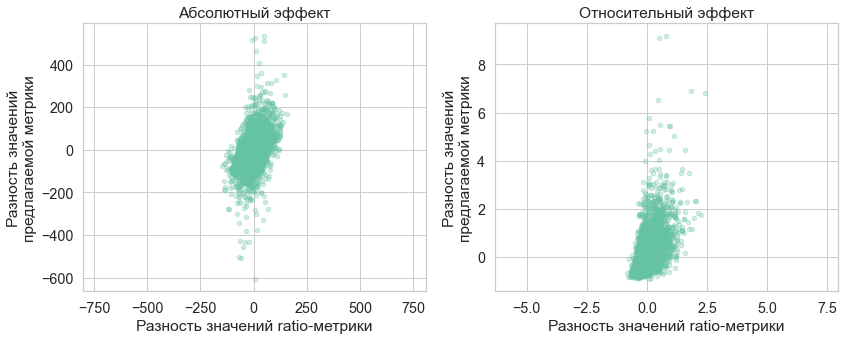

In [196]:
ratio_users = 0.1
weeks = 3
target_name = "ym:s:visitDuration"

values_absolute, values_relative = metric_sampler(
    generate_users_data, 
    metrics=[ratio_metric, bucket_metric], 
    target_name=target_name, 
    n_iter=n_iter, 
    ratio_users=ratio_users,
    weeks = weeks
)

plt.figure(figsize=(12, 5))
for i, value, title in zip(
    [1, 2],
    [values_absolute, values_relative],
    ['Абсолютный эффект', 'Относительный эффект']
):
    plt.subplot(1, 2, i)
    plt.scatter(value[0], value[1], s=20, alpha=0.3)
    plt.xlabel('Разность значений ratio-метрики')
    plt.ylabel('Разность значений\nпредлагаемой метрики')
    plt.title(title)
    plt.axis('equal')
    
plt.tight_layout()

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [39:32<00:00,  2.11it/s]


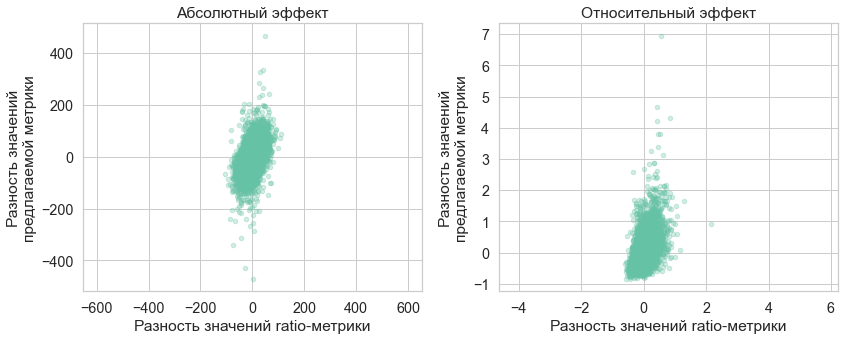

In [197]:
ratio_users = 0.2
weeks = 3
target_name = "ym:s:visitDuration"

values_absolute, values_relative = metric_sampler(
    generate_users_data, 
    metrics=[ratio_metric, bucket_metric], 
    target_name=target_name, 
    n_iter=n_iter, 
    ratio_users=ratio_users,
    weeks = weeks
)

plt.figure(figsize=(12, 5))
for i, value, title in zip(
    [1, 2],
    [values_absolute, values_relative],
    ['Абсолютный эффект', 'Относительный эффект']
):
    plt.subplot(1, 2, i)
    plt.scatter(value[0], value[1], s=20, alpha=0.3)
    plt.xlabel('Разность значений ratio-метрики')
    plt.ylabel('Разность значений\nпредлагаемой метрики')
    plt.title(title)
    plt.axis('equal')
    
plt.tight_layout()

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [50:24<00:00,  1.65it/s]


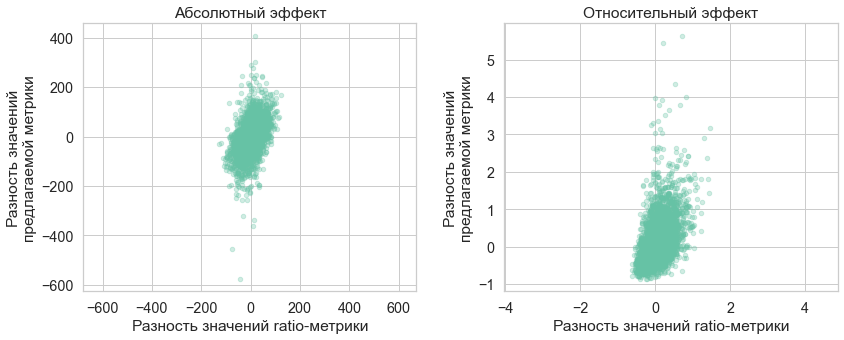

In [198]:
ratio_users = 0.1
weeks = 5
target_name = "ym:s:visitDuration"

values_absolute, values_relative = metric_sampler(
    generate_users_data, 
    metrics=[ratio_metric, bucket_metric], 
    target_name=target_name, 
    n_iter=n_iter, 
    ratio_users=ratio_users,
    weeks = weeks
)

plt.figure(figsize=(12, 5))
for i, value, title in zip(
    [1, 2],
    [values_absolute, values_relative],
    ['Абсолютный эффект', 'Относительный эффект']
):
    plt.subplot(1, 2, i)
    plt.scatter(value[0], value[1], s=20, alpha=0.3)
    plt.xlabel('Разность значений ratio-метрики')
    plt.ylabel('Разность значений\nпредлагаемой метрики')
    plt.title(title)
    plt.axis('equal')
    
plt.tight_layout()

Для 10 бакетов во всех случаях снова вышло, что на таких данных сонаправленности почти нет

С линеаризацией:

In [199]:
def linearization(
    x_data, y_data, 
    numerator_name='ym:s:pageViews', 
    denominator_name=None, 
    user_name='ym:s:clientID',
    eta=0
):
    '''
    Реализация линеаризации ratio-метрики.
    
    Аргументы:
    x_data, y_data -- таблицы данных для двух групп
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    user_name -- имя колонки с id пользователей
    eta -- параметр линеаризации
    
    Возвращает:
    x_users, y_users -- таблицу с поюзерными линеаризованными метриками,
    которые записаны в колонках linearization_values
    '''
    
    if denominator_name is None:
        x_data = x_data.copy()
        y_data = y_data.copy()
        
        denominator_name = 'ratio_denominator'
        x_data[denominator_name] = 1
        y_data[denominator_name] = 1
        
    kappa = (1-eta) * ratio_metric(x_data, numerator_name, denominator_name) \
        + eta * ratio_metric(y_data, numerator_name, denominator_name)
    
    x_users = x_data.groupby(user_name).sum()
    y_users = y_data.groupby(user_name).sum()
    
    x_users['linearization_values'] = x_users[numerator_name] \
        - kappa * x_users[denominator_name]
    y_users['linearization_values'] = y_users[numerator_name] \
        - kappa * y_users[denominator_name]
    
    return x_users, y_users

In [200]:
def linearization_metric(data, numerator_name):
    return data['linearization_values'].mean()


def metric_sampler(
    generate_sample, target_name, 
    n_iter=10000, ratio_users=0.1, weeks = 3
):
    '''
    Генерация значений разности средних по группам для разных метрик.
    
    Аргументы:
    generate_sample -- функции для семплирования выборок
    target_name -- поле для вычисления метрики
    n_iter -- количество итераций
    '''

    values_absolute = np.zeros((2, n_iter))
    values_relative = np.zeros((2, n_iter))
    
    list_real_delta = []
    list_delta = []

    # Проведение экспериментов
    for i in tqdm(range(n_iter)):
        x, y = generate_users_data(ratio_users, weeks)
        
        # линеаризованные данные
        xl, yl = linearization(
            x, y, 
            numerator_name=target_name,
            eta=0
        )
        
        # для каждой метрики используем свои данные
        for j, (metric, xv, yv) in enumerate(zip(
            [ratio_metric, linearization_metric],
            [x, xl], [y, yl]
        )):
            test = metric(xv, target_name)
            control = metric(yv, target_name)
            values_absolute[j, i] = test - control
            values_relative[j, i] = (test - control) / control

    return values_absolute, values_relative

In [201]:
ratio_users = 0.1
weeks = 3
target_name = "ym:s:pageViews"

values_absolute, values_relative = metric_sampler(
    generate_users_data, 
    target_name=target_name, 
    n_iter=n_iter, 
    ratio_users=ratio_users,
    weeks = weeks
)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [20:51<00:00,  4.00it/s]


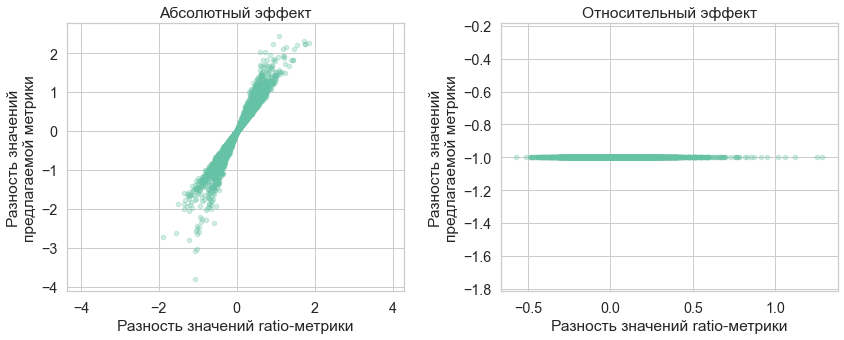

In [43]:
plt.figure(figsize=(12, 5))
for i, value, title in zip(
    [1, 2],
    [values_absolute, values_relative],
    ['Абсолютный эффект', 'Относительный эффект']
):
    plt.subplot(1, 2, i)
    plt.scatter(value[0], value[1], s=20, alpha=0.3)
    plt.xlabel('Разность значений ratio-метрики')
    plt.ylabel('Разность значений\nпредлагаемой метрики')
    plt.title(title)
    plt.axis('equal')
    
plt.tight_layout()

Для линеаризации все так и должно быть. Видим, что для абсолютного эффекта разброс вблизи нуля маленький - там как раз сужение.
Для относительного эффекта видели на семинаре, что test = metric(xv, target_name) очень близко к нулю, тогда (test - control) / control = -1 всегда, потому такой график и вышел.

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [38:56<00:00,  2.14it/s]


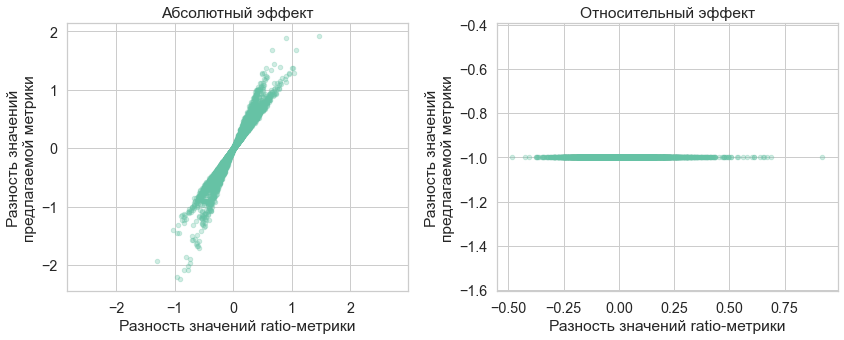

In [202]:
ratio_users = 0.2
weeks = 3
target_name = "ym:s:pageViews"

values_absolute, values_relative = metric_sampler(
    generate_users_data, 
    target_name=target_name, 
    n_iter=n_iter, 
    ratio_users=ratio_users,
    weeks = weeks
)

plt.figure(figsize=(12, 5))
for i, value, title in zip(
    [1, 2],
    [values_absolute, values_relative],
    ['Абсолютный эффект', 'Относительный эффект']
):
    plt.subplot(1, 2, i)
    plt.scatter(value[0], value[1], s=20, alpha=0.3)
    plt.xlabel('Разность значений ratio-метрики')
    plt.ylabel('Разность значений\nпредлагаемой метрики')
    plt.title(title)
    plt.axis('equal')
    
plt.tight_layout()

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [50:33<00:00,  1.65it/s]


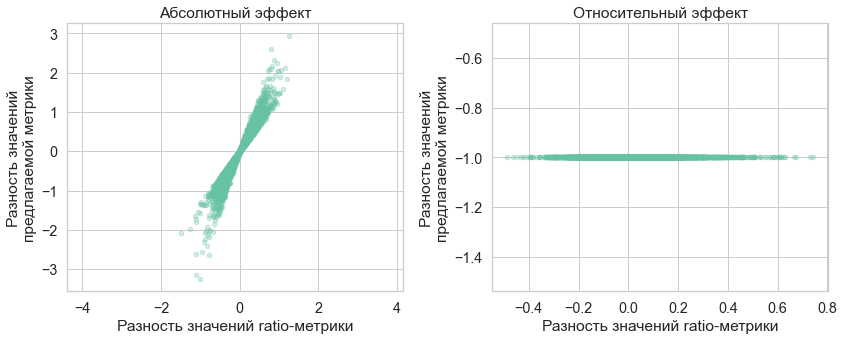

In [203]:
ratio_users = 0.1
weeks = 5
target_name = "ym:s:pageViews"

values_absolute, values_relative = metric_sampler(
    generate_users_data, 
    target_name=target_name, 
    n_iter=n_iter, 
    ratio_users=ratio_users,
    weeks = weeks
)

plt.figure(figsize=(12, 5))
for i, value, title in zip(
    [1, 2],
    [values_absolute, values_relative],
    ['Абсолютный эффект', 'Относительный эффект']
):
    plt.subplot(1, 2, i)
    plt.scatter(value[0], value[1], s=20, alpha=0.3)
    plt.xlabel('Разность значений ratio-метрики')
    plt.ylabel('Разность значений\nпредлагаемой метрики')
    plt.title(title)
    plt.axis('equal')
    
plt.tight_layout()

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [20:48<00:00,  4.01it/s]


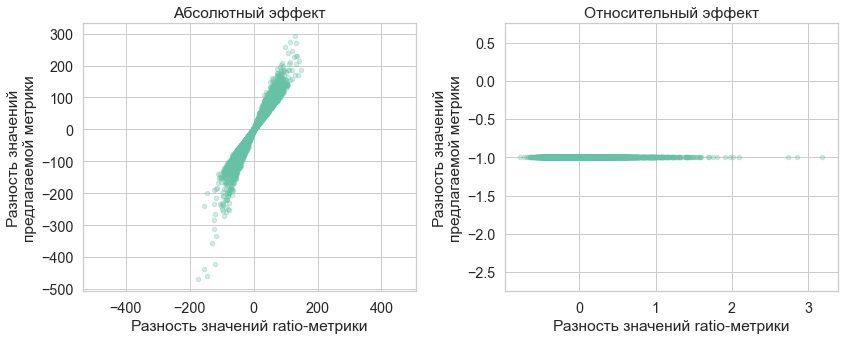

In [204]:
ratio_users = 0.1
weeks = 3
target_name = "ym:s:visitDuration"

values_absolute, values_relative = metric_sampler(
    generate_users_data, 
    target_name=target_name, 
    n_iter=n_iter, 
    ratio_users=ratio_users,
    weeks = weeks
)

plt.figure(figsize=(12, 5))
for i, value, title in zip(
    [1, 2],
    [values_absolute, values_relative],
    ['Абсолютный эффект', 'Относительный эффект']
):
    plt.subplot(1, 2, i)
    plt.scatter(value[0], value[1], s=20, alpha=0.3)
    plt.xlabel('Разность значений ratio-метрики')
    plt.ylabel('Разность значений\nпредлагаемой метрики')
    plt.title(title)
    plt.axis('equal')
    
plt.tight_layout()

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [39:24<00:00,  2.11it/s]


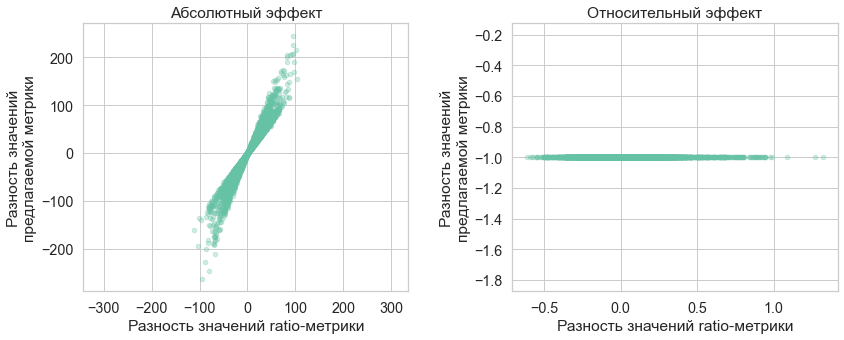

In [205]:
ratio_users = 0.2
weeks = 3
target_name = "ym:s:visitDuration"

values_absolute, values_relative = metric_sampler(
    generate_users_data, 
    target_name=target_name, 
    n_iter=n_iter, 
    ratio_users=ratio_users,
    weeks = weeks
)

plt.figure(figsize=(12, 5))
for i, value, title in zip(
    [1, 2],
    [values_absolute, values_relative],
    ['Абсолютный эффект', 'Относительный эффект']
):
    plt.subplot(1, 2, i)
    plt.scatter(value[0], value[1], s=20, alpha=0.3)
    plt.xlabel('Разность значений ratio-метрики')
    plt.ylabel('Разность значений\nпредлагаемой метрики')
    plt.title(title)
    plt.axis('equal')
    
plt.tight_layout()

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [51:04<00:00,  1.63it/s]


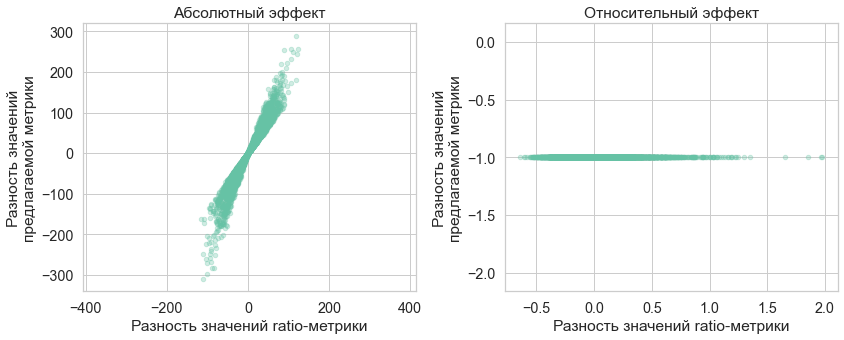

In [206]:
ratio_users = 0.1
weeks = 5
target_name = "ym:s:visitDuration"

values_absolute, values_relative = metric_sampler(
    generate_users_data, 
    target_name=target_name, 
    n_iter=n_iter, 
    ratio_users=ratio_users,
    weeks = weeks
)

plt.figure(figsize=(12, 5))
for i, value, title in zip(
    [1, 2],
    [values_absolute, values_relative],
    ['Абсолютный эффект', 'Относительный эффект']
):
    plt.subplot(1, 2, i)
    plt.scatter(value[0], value[1], s=20, alpha=0.3)
    plt.xlabel('Разность значений ratio-метрики')
    plt.ylabel('Разность значений\nпредлагаемой метрики')
    plt.title(title)
    plt.axis('equal')
    
plt.tight_layout()

Для всех случаев линеаризация показывает хорошую сонаправленность

**2.** Давай применим CUPED к линеаризованным данным со стандартной ковариатой &mdash; значение исследуемой метрики для пользователя на предэкспериментальном периоде. Однако, в этом случае у нас нет соответствующих значений для новых пользователей. В таком случае можно сделать новый категориальный признак &mdash; имеется ли у пользователя активность во время предэкспериментального периода. Для тех, у кого не было активности, значение ковариаты можно заменить на константу. Далее использовать CUPED со стратификацией по дополнительному категориальному признаку. Используй также стратификацию по хотя бы одному другому признаку.


Бери код линеаризации с занятия, а также реализацию теста с линеаризацией и CUPED. В общем, из нескольких реализаций надо сделать одну общую.

Провалидируй этот подход по историческим данным.

*Кажется, на основе существующих функций AA-теста надо написать еще одну :)*

Попробуем в качестве страты взять данные о том, новый ли это пользователь или нет. Новый пользователь еще не знаком с сайтом и долго его изучает в первый раз, таким образом, в этом случае видим увеличение таргета

In [354]:
import warnings 
warnings.filterwarnings('ignore')

In [526]:
def generate_users_data(
    ratio_users=0.1, weeks=3
):
    
    start = int(np.random.randint(737909 +  weeks * 7, 738181 - weeks * 7 + 1, 1))
    data1 = data[data['info_about_date'] <= start + weeks * 7]
    data1 = data1[start <= data1['info_about_date']]
    data1 = data1.set_index(np.arange(len(data1)))
    
    data2 = data[data['info_about_date'] <= start]
    data2 = data2[start - weeks * 7 <= data2['info_about_date']]
    data2 = data2.set_index(np.arange(len(data2)))
    
    indices = np.random.choice(len(np.unique(data1['ym:s:clientID'])), 
                               int(ratio_users * len(np.unique(data1['ym:s:clientID'])))) 
    users_x = data1.groupby('ym:s:clientID').mean().index[indices[:len(indices) // 2]]
    users_y = data1.groupby('ym:s:clientID').mean().index[indices[len(indices) // 2:]]
    
    data1['x'] = data1['ym:s:clientID'].apply(lambda x: x in users_x)
    data1['y'] = data1['ym:s:clientID'].apply(lambda x: x in users_y)
    x = data1[data1['x']]
    y = data1[data1['y']]
    x['period'] = 1
    y['period'] = 1

    data2['x'] = data2['ym:s:clientID'].apply(lambda x: x in users_x)
    data2['y'] = data2['ym:s:clientID'].apply(lambda x: x in users_y)
    x1 = data2[data2['x']]
    y1 = data2[data2['y']]
    x1['period'] = 0
    y1['period'] = 0

    return pd.concat((x,x1),axis=0), pd.concat((y,y1),axis=0)

In [527]:
def weighted_post_var(data, sample_name, strata_weights=None):
    '''
    Вычисляет взвешенную дисперсию при постстратификации.
    
    :param data: данные
    :param strata_weights: веса страт
    :return: дисперсия
    '''
    
    strata_vars = data.groupby(by='strata')[sample_name].var()
    weighted_var = (strata_vars * strata_weights).sum() / len(data)
    post_addition = (strata_vars * (1-strata_weights)).sum() / (len(data)**2)
    return weighted_var + post_addition

In [528]:
def weighted_mean(data, sample_name, strata_weights):
    '''
    Вычисляет взвешенное среднее.
    
    :param data: данные
    :param weights: веса страт
    :return: взвешенное среднее
    '''

    strata_means = data.groupby(by='strata')[sample_name].mean()
    return (strata_means * strata_weights).sum()

In [529]:
# Взвешенная ковариация при постстратификации
def weighted_post_cov(x_data, y_data, sample_name, covariate_name, strata_weights=None):
    
    cov_strata_0 = 0
    cov_strata_0 += np.cov(x_data[x_data.strata == 0][covariate_name], x_data[x_data.strata == 0][sample_name])[0, 1]
    cov_strata_0 += np.cov(y_data[y_data.strata == 0][covariate_name], y_data[y_data.strata == 0][sample_name])[0, 1]
    cov_strata_1 = 0
    cov_strata_1 += np.cov(x_data[x_data.strata == 1][covariate_name], x_data[x_data.strata == 1][sample_name])[0, 1]
    cov_strata_1 += np.cov(y_data[y_data.strata == 1][covariate_name], y_data[y_data.strata == 1][sample_name])[0, 1]
    cov_strata = np.array([cov_strata_0, cov_strata_1])
    cov_weighted = (cov_strata * strata_weights).sum() / len(x_data)
    return cov_weighted + (cov_strata * (1-strata_weights)).sum() / (len(x_data)**2)

In [530]:
def cuped_transform(
    x_data, y_data, 
    sample_name='pilot', cuped_name='cuped', covariate_name='prepilot', 
    paired=False, return_theta=False, strata_weights=None
):
    '''
    Выполняет CUPED-преобразование.
    
    :param x_data: данные тестовой группы
    :param y_data: данные контрольной группы
    :param sample_name: имя столбца с целевым признаком
    :param cuped_name: имя столбца, в который записать преобразование
    :param covariate_name: имя столбца-ковариаты
    :param paired: являются ли выборки парными
    :param return_theta: возвращать ли значение theta
    :return: таблицы с добавленными столбцами и theta
    '''
    
    theta = (weighted_post_cov(x_data, y_data, sample_name, covariate_name, strata_weights)) / \
                (weighted_post_var(x_data, sample_name, strata_weights) + weighted_post_var(y_data, sample_name, strata_weights))
    
    # Делаем преобразование
    x_data[cuped_name] = x_data[sample_name] - theta*x_data[covariate_name]
    y_data[cuped_name] = y_data[sample_name] - theta*y_data[covariate_name]
    
    if return_theta:
        return x_data, y_data, theta
    else:
        return x_data, y_data

In [538]:
def linearization_ratio_ttest(
    x_data, y_data, 
    cuped=True,
    numerator_name='ym:s:pageViews', 
    denominator_name=None, 
    user_name='ym:s:clientID',
    eta=0, alpha=0.05
):
    '''
    Реализация t-test для ratio-метрик с использованием линеаризации и CUPED.
    В качестве ковариаты используется значение линеаризованной метрики на предпериоде.
    
    Аргументы:
    x_data, y_data -- таблицы данных для двух групп
    cuped -- применять ли CUPED-преобразование
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    user_name -- имя колонки с id пользователей
    eta -- параметр линеаризации
    alpha -- уровень значимости
    
    Возвращает:
    stat -- статистика критерия
    pvalue -- соответствующее p-value
    '''
    
    # Линеаризация на экспериментальном периоде
    x_users_pilot, y_users_pilot = linearization(
        x_data[x_data['period'] == 1], 
        y_data[y_data['period'] == 1],
        numerator_name=numerator_name, 
        denominator_name=denominator_name, 
        user_name=user_name,
        eta=eta
    )
    
    name = 'linearization_values_cuped' if cuped else 'linearization_values'
    sample_name = 'linearization_values'
    
    if cuped:
        # Линеаризация на предэкспериментальном периоде
        x_users_prepilot, y_users_prepilot = linearization(
            x_data[x_data['period'] == 0], 
            y_data[y_data['period'] == 0],
            numerator_name=numerator_name, 
            denominator_name=denominator_name, 
            user_name=user_name,
            eta=eta
        )

        # Соединяем две таблицы данных для каждой из групп
        x_users_pilot = x_users_pilot.join(
            x_users_prepilot, lsuffix='', rsuffix='_prepilot'
        )
        y_users_pilot = y_users_pilot.join(
            y_users_prepilot, lsuffix='', rsuffix='_prepilot'
        )
        
        # Заполняем пропуски для новых пользователей
        x_users_pilot['linearization_values_prepilot'] = x_users_pilot['linearization_values_prepilot'].fillna(x_users_pilot['linearization_values_prepilot'].mean())
        y_users_pilot['linearization_values_prepilot'] = y_users_pilot['linearization_values_prepilot'].fillna(y_users_pilot['linearization_values_prepilot'].mean())
        
        # Формируем страты
        x_users_pilot['strata'] = x_users_pilot['ym:s:isNewUser'].apply(lambda x: 0 if x == 0 else 1)
        y_users_pilot['strata'] = y_users_pilot['ym:s:isNewUser'].apply(lambda x: 0 if x == 0 else 1)
        
        # Чтобы размеры были одинаковые у групп
        mini = min(len(x_users_pilot), len(y_users_pilot))
        x_users_pilot = x_users_pilot[:mini]
        y_users_pilot = y_users_pilot[:mini]
        
        # Веса страт
        strata_weights = np.array([data['ym:s:isNewUser'].value_counts()[0], data['ym:s:isNewUser'].value_counts()[1]]) / len(data)
        
        # Сделаем cuped-преобразование
        x_data, y_data = cuped_transform(
            x_users_pilot, y_users_pilot, 
            sample_name='linearization_values', 
            cuped_name=name, 
            covariate_name='linearization_values_prepilot', 
            strata_weights=strata_weights
        )
        
    else:
        # Если не делаем CUPED, то используем сами линеаризованные данные
        x_data, y_data = x_users_pilot, y_users_pilot
        
    # Код с семинара по стратификации
    mean1 = weighted_mean(x_data, name, strata_weights) - weighted_mean(y_data, name, strata_weights)
    mean2 = weighted_mean(y_data, sample_name, strata_weights)
    var1  = (weighted_post_var(x_data, name, strata_weights) + weighted_post_var(y_data, name, strata_weights) - 2 * np.cov(x_data[name], y_data[name])[0, 1]) / len(x_data)
    var2  = weighted_post_var(y_data, sample_name, strata_weights) / len(x_data)
    cov = np.cov(np.array(x_data[name]) - np.array(y_data[name]), y_data[sample_name])[0, 1] / len(x_data)
    
    stat = (weighted_mean(x_data, name, strata_weights) - weighted_mean(y_data, name, strata_weights))/weighted_mean(y_data, sample_name, strata_weights)
    std = np.sqrt(var1 / mean2 ** 2 + var2 * mean1 ** 2 / mean2 ** 4 - 2 * cov * mean1 / mean2 ** 3)

    t_stat = stat / std
    pvalue = 2*sps.norm.sf(np.abs(t_stat))  

    q = sps.norm.ppf(1 - 0.05/2)
    left_bound = stat - q*std
    right_bound = stat + q*std
    
    return stat, left_bound, right_bound, pvalue

In [536]:
def AA_test(
    test, 
    n_iter=10000, alpha=0.05, 
    effect=0, weeks=3, ratio_users=0.1, 
    relative_effect=True, feature_values='ym:s:pageViews'
):    
    '''
    Проведение серии AA-тестов на искусственных выборках.
    
    Аргументы:
    test -- статистический критерий
    generate_sample_x -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости
    effect -- величина эффекта для оценки мощности
    relative_effect -- относительный или абсолютный эффект
    feature_values -- название признака, для которого проводится тест
    '''

    n_errors = 0  # количество отвержений H_0

    # Проведение экспериментов
    for _ in tqdm(range(n_iter)):
        # Генерируем выборки
        x, y = generate_users_data(ratio_users, weeks)
        
        # Добавляем эффект, если хотим оценить мощность
        if relative_effect:
            x[feature_values] *= 1 + effect * (x['period'] == 1)
        else:
            x[feature_values] += effect * (x['period'] == 1)
        
        n_errors += test(x, y)

    # Реальный уровень значимости
    real_alpha, left_alpha, right_alpha = calculate_real_alpha(n_errors, n_iter)
    draw_interval(real_alpha, left_alpha, right_alpha, alpha=alpha)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [35:24<00:00,  2.35it/s]


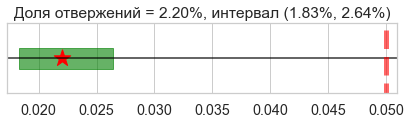

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [32:14<00:00,  2.58it/s]


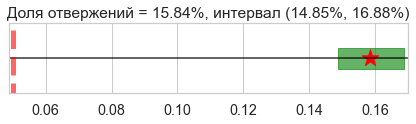

In [181]:
weeks = 3
ratio_users = 0.1
feature_values = 'ym:s:pageViews'

for effect in [0, 0.05]:
    AA_test(test=lambda x, y: linearization_ratio_ttest(x, y, cuped=True, eta=0.5)[-1] < alpha, 
            n_iter=n_iter, 
            effect=effect, 
            weeks=weeks, 
            ratio_users=ratio_users, 
            feature_values=feature_values)

**Вывод:** Вроде ошибка первого рода и небольшая, но мощность маловата, что-то не совсем так как надо пошло

Вот и все, задание закончилось, вроде же хорошо мы вместе решили задачки, правда?)

А теперь все перепроверь, поработай над качеством оформления и отправляй работу. Не забудь покушать, и на лекцию!